<p style="text-align:center">
NetSci 2019 Network Neuroscience Satellite Conference </p>


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/NetNeurosci2019/blob/master/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Demonstration </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>Satoru Hayasaka</b></p>

<hr style="height:5px;border:none" />

# 1. Preparation
<hr style="height:1px;border:none" />

As a preparation for a demonstration on node-wise thresholding, I calculate a correlation matrix from a rs-fMRI data set. Nodes are defined by Craddock's Rt 2-level atlas, with K=200.

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community   # Louvain method for modular partition

###### Parameters
targetDeg = 10  # target average degree


###### Loadin the mean ROI time series data (previously calculated)
f_TS = 'Oxford_sub16112_rt2_K200.npz'
infile = np.load(f_TS)
ts = infile['ts']   # Time series array, rows: time points, columns: ROIs
nodes = infile['nodes']   # List of nodes (or ROI IDs). They are not sequential
xyz = infile['xyz']   # XYZ coordinates (in brain space) of each ROI center

###### Calculating the correlation matrix
R = np.corrcoef(ts, rowvar=False)
# zero-ing the main diagonal to avoid self-loops
for iRow in range(R.shape[0]):
    R[iRow,iRow] = 0

Here is the correlation matrix we will work with.

In [3]:
%matplotlib inline

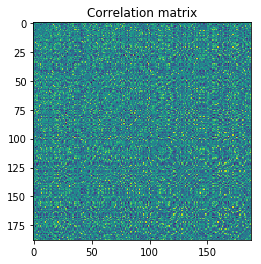

In [4]:
# showing the correlation coefficient
plt.imshow(R)
plt.title('Correlation matrix')
plt.show()

# 2. Thresholding
<hr style="height:1px;border:none" />

In the Python program **`net_builder.py`**, there are three functions to threshold a correlation matrix.

* **`net_builder_RankTh`**: Node-wise thresholding, with a desired *d*-level.
* **`net_builder_HardTh`**: Hard thresholding, network formed at a desired average degree.
* **`net_builder_HardTh_density`**: Hard thresholding, network formed at a desired edge density.

The parameters for these functions are explained in their respective function. 

As a demonstration, we generate a network with node-wise thresholding with d=10 first.


In [5]:
# importing the thresholding functions
from net_builder import net_builder_RankTh, net_builder_HardTh

# Network with node-wise thresholding, d=10
d = 10
G_nodewise = net_builder_RankTh(R, nodes, d)

For the sake of comparison, we generate another network with the same number of nodes & edges via hard thresholding.

In [6]:
# calculating the target degree to match the node-wise thresholding network
targetK = 2*len(G_nodewise.edges())/len(G_nodewise.nodes())
# actual hard thresholding
G_hardth = net_builder_HardTh(R, nodes, targetK)

Now let's visualize both networks.

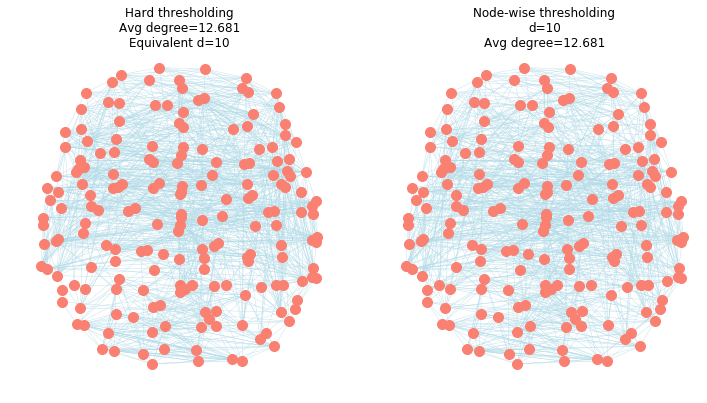

In [31]:
###### visualizing the network
# dictionary of xy-coordinates
pos = {}
for i in range(len(nodes)):
    pos[nodes[i]] = xyz[i,:2]

    
# first, hard-thresholding network
plt.figure(figsize=[12,6])
plt.subplot(121)
nx.draw_networkx_nodes(G_hardth, pos, node_color='salmon',
                       node_size=100)
nx.draw_networkx_edges(G_hardth, pos, width=0.33,
                       edge_color='lightblue')
plt.title('Hard thresholding\nAvg degree=%5.3f\nEquivalent d=%2d' % (targetK, d))
plt.axis('off')

# second, rank-thresholding network
plt.subplot(122)
nx.draw_networkx_nodes(G_nodewise, pos, node_color='salmon',
                       node_size=100)
nx.draw_networkx_edges(G_nodewise, pos, width=0.33,
                       edge_color='lightblue')
plt.title('Node-wise thresholding\nd=%2d\nAvg degree=%5.3f' % (d, targetK))
plt.axis('off')

plt.show()


Just for fun, let's plot degree distributions.

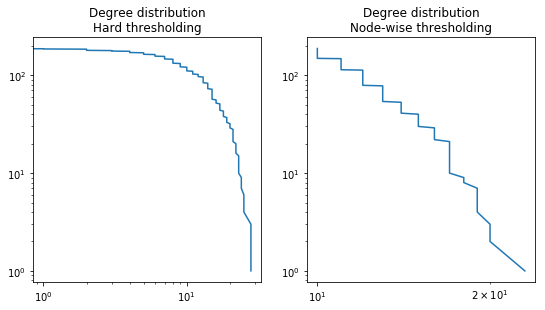

In [13]:
##### Degree sequence
k_hardth = [d for n, d in G_hardth.degree()]
k_nodewise = [d for n, d in G_nodewise.degree()]

###### Cumulative distribution plots
sk_hardth = sorted(k_hardth, reverse=True) 
sk_nodewise = sorted(k_nodewise, reverse=True) 


plt.figure(figsize=[9,4.5])

plt.subplot(121)
plt.plot(sk_hardth, np.arange(1,len(sk_hardth)+1))
plt.title('Degree distribution\nHard thresholding')
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.plot(sk_nodewise, np.arange(1,len(sk_nodewise)+1))
plt.title('Degree distribution\nNode-wise thresholding')
plt.xscale('log')
plt.yscale('log')

plt.show()


And finally, let's take a look at modular organization (determined by the Louvain method).

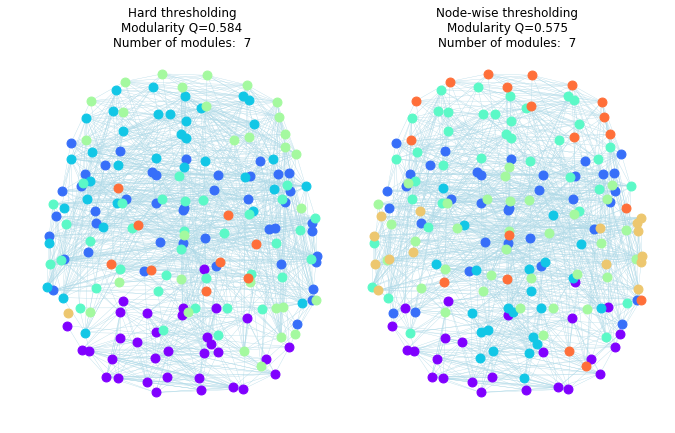

In [32]:
##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


###### drawing the graph with modular partition
plt.figure(figsize=[9,5.5])
    
### Hard thresholding network
partition_hardth = community.best_partition(G_hardth)
Q_hardth = community.modularity(partition_hardth, G_hardth)

plt.subplot(121)
nComm = max([comm for comm in partition_hardth.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
nx.draw_networkx_edges(G_hardth, pos, width=0.33,
                        edge_color='lightblue')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_hardth.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_hardth, pos, 
                            nodelist=nodeList,
                            node_color = np.array([node_color_list(iComm)]),
                            node_size=80)
    plt.title('Hard thresholding' + 
              '\nModularity Q=%5.3f\nNumber of modules: %2d' % 
              (Q_hardth, nComm))
    plt.axis('off')

    
### Node-wise thresholding network
partition_nodewise = community.best_partition(G_nodewise)
Q_nodewise = community.modularity(partition_nodewise, G_nodewise)

plt.subplot(122)
nComm = max([comm for comm in partition_nodewise.values()])+1
node_color_list = get_cmap(nComm+1,'rainbow')
nx.draw_networkx_edges(G_nodewise, pos, width=0.33,
                        edge_color='lightblue')
for iComm in range(nComm):
    nodeList = [iNode for iNode,Comm in partition_nodewise.items()
                if Comm==iComm]
    nx.draw_networkx_nodes(G_nodewise, pos, 
                            nodelist=nodeList,
                            node_color = np.array([node_color_list(iComm)]),
                            node_size=80)
    plt.title('Node-wise thresholding' + 
              '\nModularity Q=%5.3f\nNumber of modules: %2d' % 
              (Q_nodewise, nComm))

    plt.axis('off')

    
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.925)
plt.show()